In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import fnmatch
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ruptures as rpt


In [2]:
from lib.data_classes.pffpFolder import pffpDataFolder
from lib.signal_processing.signal_function import moving_average, find_deriv_change, find_drops

In [3]:
def get_change_points(signal, n_change_points= 1, model = "l1"):
    # Purpose: Use second order stationarity as a condtion to find the change points
    # Used by Hunstein et al. in https://ascelibrary.org/doi/full/10.1061/JGGEFK.GTENG-11550
    # For determining the mudline

    # Possible models are: 
    # l1: Penalizes the absolute difference between the data points and their estimated value after the change point. This model assumes that the changes are abrupt.
    # l2: Penalizes the squared difference between the data points and their estimated value after the change point. This model assumes that the changes are smooth.
    # rbf: Uses Gaussian basis functions to model the data. This model is suitable for detecting changes in periodic or oscillatory data.
    # linear: Assumes that the data follows a linear trend with abrupt changes.
    # discrete: Assumes that the data points are independent and identically distributed, with different means before and after the change point.
    # normal: Assumes that the data points are normally distributed, with different means and variances before and after the change point.
    # full: Uses a custom model defined by the user. You can specify your own cost function and penalty.

    # Apply change point detection
    algo = rpt.Dynp(model=model).fit(signal)
    result = algo.predict(n_bkps=n_change_points)  # You can specify the number of change points you want to detect

    # Zero shift the indices and return the results
    # Returns the change points and the last index
    return np.array(result)-1

In [4]:
# Testing the binary file classa
#TODO: for some reason I need the full path to read the files, I'll need to look into this in the future
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\test"
folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Potomac_to Jonathan"
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Clay_Air_Drops_GBE_AdamsPoint"
calibration_dir = r"BlueDrop_Calibration_Factors.xlsx"

In [5]:
# TODO: Combine the pffp_id and the read_calibration_excel_sheet just have the objet call inside

test_folder = pffpDataFolder(folder_dir, pffp_id = 3, calibration_factor_dir=calibration_dir)
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1 
Date range: Not set 
PFFP id: 3                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: Not set                 
Num files with drops: Not Set


In [6]:
# Read the calibration data
test_folder.read_calibration_excel_sheet()
test_folder.calibration_excel_sheet

# Select the specific calibration params
test_folder.get_sensor_calibration_params("Sequim_2021")

# Init a pffpFile instances for each binary file and store the results in the folder
test_folder.store_pffp_files(recursive = False)

In [7]:
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1 
Date range: Not set 
PFFP id: 3                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 9                 
Num files with drops: Not Set


In [8]:
# Analyze the selected pffp files
test_folder.analyze_all_files(store_df=False, use_pore_pressure=True)

Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\no_drop_folder' already exists.
Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\funky' already exists.

Progress analysing drops...
[==================================================] 100.00% ETA (min): 0.083
Initial analysis complete!


In [9]:
test_folder.process_drop_files()


Progress processing drops in files...
[==================================================] 100.00% ETA (min): 0.081

In [10]:
print(test_folder.pffp_drop_files[0].drops[0])

----- Drop Info ----- 
Containing file: bLog0D2F.bin 
File Drop Index: 1 
Water Drop: None            
Drop indices: {'release_index': 35277, 'start_impulse_index': 42139, 'end_impulse_index': 42535}


In [11]:
print(test_folder.pffp_drop_files[3])

File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\bLog0D33.bin 
Num Drops in file: 1         
Drop Date: 2022-10-26 
Drop Time: 12:53:33         
df stored: False


File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\bLog0D37.bin 
Num Drops in file: 1         
Drop Date: 2022-10-26 
Drop Time: 12:57:33         
df stored: False


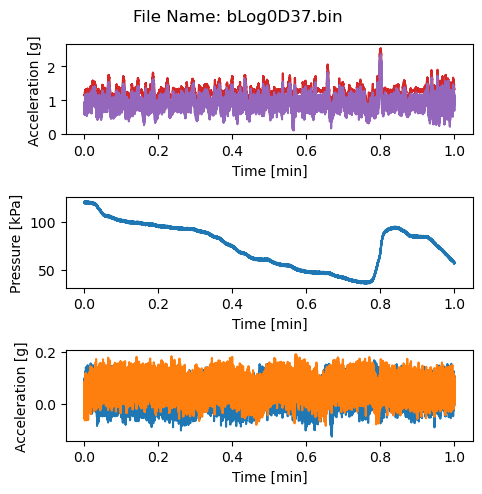

In [12]:
start = 5
end = 6
for file in test_folder.pffp_drop_files[start:end]:
    print(file)
    file.quick_view(interactive = False, figsize = [5, 5], legend = False)

# print(test_folder.pffp_funky_files[index])
# test_folder.pffp_funky_files[index].quick_view(interactive = False)


In [13]:
# Plot the drops
index = 0
file = test_folder.pffp_drop_files[index]
# file.quick_view()
drop = file.drops[0]
print(file)

File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\bLog0D2F.bin 
Num Drops in file: 1         
Drop Date: 2022-10-26 
Drop Time: 12:49:32         
df stored: False


In [14]:
print(drop)

----- Drop Info ----- 
Containing file: bLog0D2F.bin 
File Drop Index: 1 
Water Drop: None            
Drop indices: {'release_index': 35277, 'start_impulse_index': 42139, 'end_impulse_index': 42535}


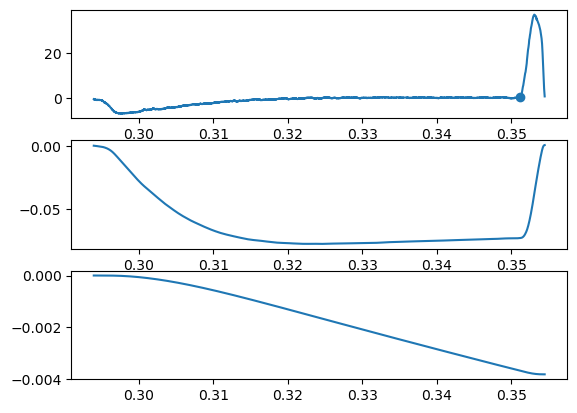

In [15]:
# Plot the drop data
df = drop.whole_drop_df

fig, axs = plt.subplots(ncols = 1, nrows = 3)

axs[0].plot(df["Time"], df["accel"])
i = drop.drop_indices["start_impulse_index"]
axs[0].scatter(df["Time"][i-1], df["accel"][i-1])
axs[1].plot(df["Time"], df["velocity"])
axs[2].plot(df["Time"], df["displacement"])

In [16]:
print(min(df["velocity"]))
print(max(drop.impulse_df["velocity"]))

-0.07783490491569603
0.07370784117412342


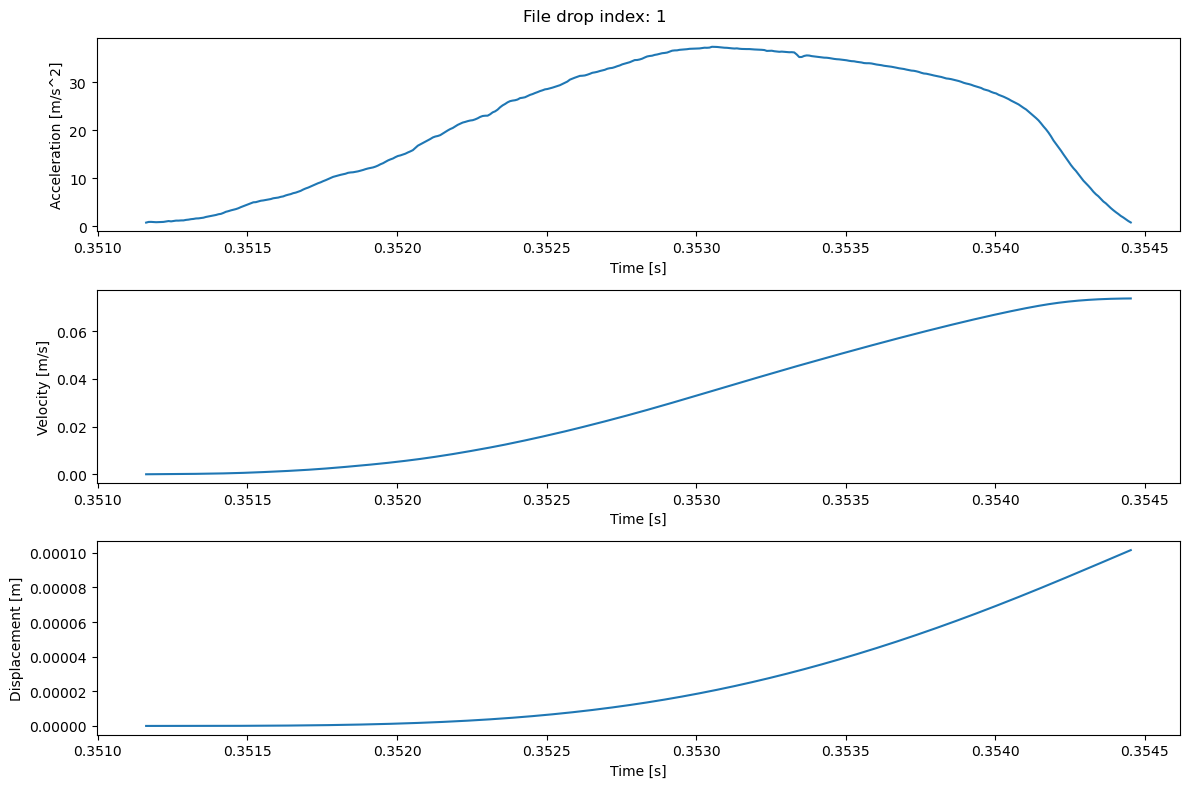

In [17]:
drop.quick_view_impulse(interactive=False)